# Анализ товарного ассортимента интернет-магазина  «Пока все ещё тут»

Цель проекта: анализ товарного ассортимента для оптимизации закупок и хранения интернет-магазина на основе данных о совершенных покупках.

In [1]:
pip install pymystem3

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.stats as stats
from scipy.stats import mstats
from scipy import stats as st
from pymystem3 import Mystem

from collections import Counter

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)


In [3]:
df = pd.read_csv(r'C:\Users\User\Desktop\Дипломный проект\ecommerce_dataset.csv')

In [4]:
#задаем функцию для описания датафрейf
def info_data(data_frame):
    print('Информация о колонках\n')
    data_frame.info()
    
    print('\nПервые 10 строк')
    display(data_frame.sample(10))
    
    print('\nКоличество дубликатов в колонках')
    display(data_frame.duplicated().sum())
    
    print('\nКоличество пропусков в колонках')
    display(data_frame.isna().sum())
    
    return

In [5]:
info_data(df)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB

Первые 10 строк


,date,customer_id,order_id,product,quantity,price
5174,2019061217,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Патиссона сорт НЛО Белый, кассета по 6шт",1,120.00
6524,2019100613,6da625e0-d187-456a-bf0a-44bbc4f6d26b,72869,Ящик для хранения Фимако Люкс плетеный с крышк...,2,749.00
5586,2019062520,48294bee-94cc-4eed-a7c0-7c6848b349fe,14878,Петуния Surfinia Crazy Pink розовая с прожилко...,1,90.00
5632,2019070212,33e24a97-916d-4aa8-b839-a805b34f3b94,14884,Подвесное кашпо Калибрахоа Mini Famous Double ...,2,488.00
2886,2019041614,42f210be-2e9c-43fa-b65a-e7891d90b98b,14651,Бальзамин Валера рассада однолетних цветов в к...,1,210.00
1306,2018122212,4df3b667-e336-4b94-ac2d-e8051b76fd94,69506,"Чайный набор СЕЛЬМА 220мл, G9434, Luminarc, Фр...",1,802.00
5997,2019073010,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
5330,2019061513,a81b03ba-c4cf-47cb-bf53-fd9ffb65f568,71713,Гладильная доска НИКА Бест 122х40 см НБ,1,1574.00
5231,2019061317,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Горный, кассета по 6шт",1,120.00
564,2018103115,ada6350f-eafb-453a-b822-23d2c8eabac1,68813,"Кувшин пластмассовый с крышкой ""Кумган"" 2,0 л ...",1,149.00



Количество дубликатов в колонках


0


Количество пропусков в колонках


date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

### 1.1. Актуализация данных

In [6]:
# приведем значения в столбце с датой в нудных для нас формат:
df['date'] = pd.to_datetime(df['date'], format= '%Y%m%d%H')
df['date']= pd.to_datetime(df['date']).dt.date
df['date'] = pd.to_datetime(df['date'])

In [7]:
print('Исследуемый период с', df['date'].min(), 'по', df['date'].max())

Исследуемый период с 2018-10-01 00:00:00 по 2019-10-31 00:00:00


Так как в дальнейшем наше исследование будет строиться на предположениях о сезонах покупок, осень может превалировать над остальными, так как в данных будут 2 октября разных годов. Актуализируем временной период исследования:


In [8]:
df=df.query('date < "2019-10-01"')

In [9]:
#выявляем неявные дубликаты:
abnormal_oreders=df.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1')
print('Уникальные заказы с разными пользователями:', abnormal_oreders.shape[0])

Уникальные заказы с разными пользователями: 26


In [10]:
#вырезаем эти данные:
df = df.query('order_id not in @abnormal_oreders.index')

In [11]:
#теперь проверяем на одинаковые заказы с разными датами:
abnormal_oreders_2 = df.groupby('order_id').agg({'date':'nunique'}).query('date > 1').sort_values(by='date', ascending=False)
print('Уникальные заказы с разными датами:', abnormal_oreders_2.shape[0])

Уникальные заказы с разными датами: 150


In [12]:
abnormal_oreders_2

,date
order_id,
70960,53
14833,22
69162,15
71148,11
13547,7
...,...
69750,2
69726,2
69708,2


165 заказов разбросаны по разным датам. посмотрим поподробнее:

In [13]:
df[df['order_id'] == 70960]

,date,customer_id,order_id,product,quantity,price
2589,2019-04-01,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2600,2019-04-02,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2622,2019-04-03,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2718,2019-04-07,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2734,2019-04-08,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2762,2019-04-09,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2815,2019-04-12,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2820,2019-04-13,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2845,2019-04-14,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00
2854,2019-04-15,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.00


Не выглядит нормально. Это похожк на сбой в логах. Даже если бы это был оптовый покупатель, он не мучился бы с оформлением по одной штуке. Может быть, сумка лежала у него в избранном, и добавлялась в корзину каждый раз, когда он в нее что-то складывал. Дропнем данные так, чтобы для каждого товара осталась последняя дата заказа:

In [14]:
df = df.drop_duplicates(subset=['customer_id', 'product', 'order_id', 'quantity', 'price'], keep = 'last')

In [15]:
#закралось подозрение про оптовиков, посмотрим, какие товары востребованы:
df[['product','quantity']].sort_values('quantity', ascending = False).head(20)

,product,quantity
5456,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000
5071,Вешалки мягкие для деликатных вещей 3 шт шоколад,334
3961,Муляж ЯБЛОКО 9 см красное,300
1158,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200
568,Муляж ЯБЛОКО 9 см красное,170
266,"Крепеж для пружины дверной, 1107055",150
267,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150
2431,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150
586,Муляж ЯБЛОКО 9 см красное,140
1555,Щетка для мытья посуды КОЛИБРИ М5202 большая,100


Тысяча вантузов за год, в то время как вторая по популярности позиция отстает почти в 3 раза! Обрезаем данные еще, это выброс:


In [16]:
df.drop(df.loc[df['quantity']==1000].index, inplace=True)

In [17]:
df.shape[0]

4595

Мы удалили приличное количество данных. Зато в них будет меньше шумов и достовернее выводы.

## 1.2. Добавление расчетных столбцов:

In [18]:
#создаем столбец месяца в виде даты:
df['month_as_date']=df['date'].values.astype('datetime64[M]')

In [19]:
#и столбец с порядковым номером месяца:
df['month']= df['date'].dt.month

In [20]:
#столбец с выручкой:
df['revenue']=df['quantity']*df['price']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4595 entries, 0 to 6479
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4595 non-null   datetime64[ns]
 1   customer_id    4595 non-null   object        
 2   order_id       4595 non-null   int64         
 3   product        4595 non-null   object        
 4   quantity       4595 non-null   int64         
 5   price          4595 non-null   float64       
 6   month_as_date  4595 non-null   datetime64[ns]
 7   month          4595 non-null   int64         
 8   revenue        4595 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 359.0+ KB


### 1.3. Выводы по итогам предобработки:

В данных нет пропусков, NaNов или каких либо неадекватных отрицательных чисел, но огромное количество неявных задвоений. По итогам предобраблотки вместо 6737 строк осталось 4595. Мне видится это ошибкой в логах/учете пользовательской активности.

## 2. Исследовательский анализ данных

### 2.1. Общие сведения о продажах:

In [22]:
#Общая выручка в исследуемый период:
print('Общая выручка составила:', df['revenue'].sum(), 'у.е.')

Общая выручка составила: 3213274.0 у.е.


Достаточно ожидаемо выпучка больше всего в предновогодние месяцы, в апреле (там обычно Пасха), и феврале (День Святого Валентина).

In [23]:
#помесячная выручка:
df.groupby('month').agg({'revenue':'sum'}).sort_values(by='revenue', ascending=False)


,revenue
month,
11,359772.00
10,350374.00
12,342174.00
4,316122.00
2,304924.00
3,250669.00
6,238483.00
1,234273.00
5,229786.00


In [24]:
#посмотрим, покупают ли в данные месяцы товары дороже или проосто больше:
df.groupby('month').agg({'order_id':'nunique'}).sort_values(by='order_id', ascending=False)

,order_id
month,
2,287
12,276
4,264
3,243
10,237
11,204
7,197
9,181
5,176


В феврале и декабре покупают просто больше.

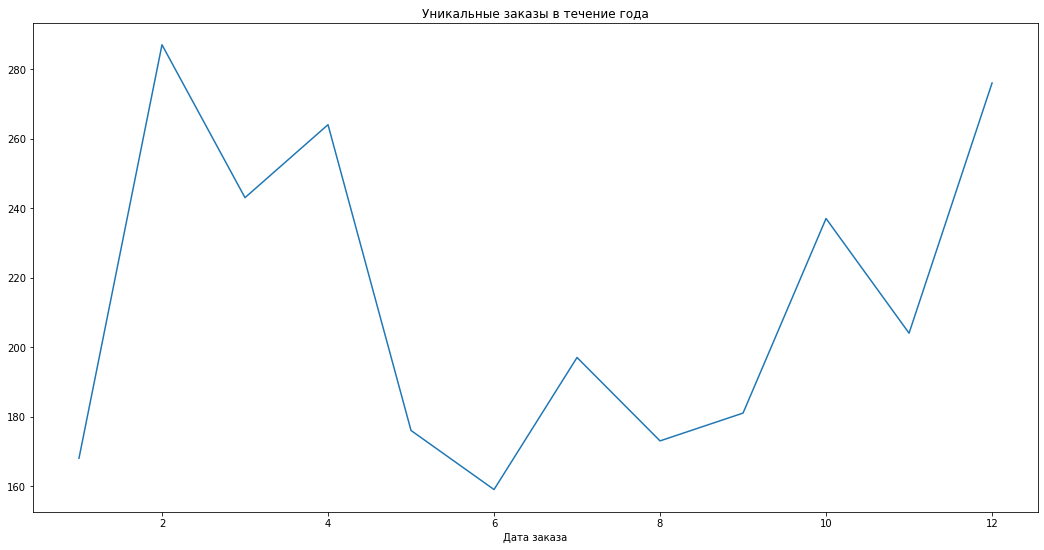

In [25]:
df.groupby('month').agg({'order_id':'nunique'}).plot(figsize=(18, 9), legend=False)
plt.title('Уникальные заказы в течение года')
plt.xlabel('Дата заказа')
plt.show()

Летние месяцы - самые провальные для продаж. Рассада куплена и на дачу увезена.

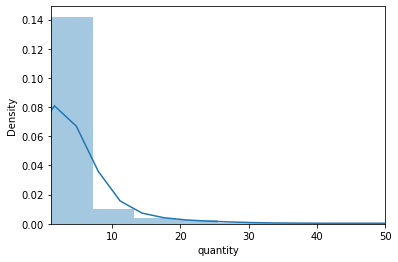

In [26]:
# Посмотрим, какие обычно формируются заказы в разрезе количества входящих единиц товара:
plt.xlim(1,50)
sns.distplot(df.groupby('product')['quantity'].sum(), bins = 100);

По поводу оптовиков: мы правильно удалили 1000 вантузов, так как интерент-магазин рассчитан на разницу: абсолютное большинство товаров продается до 8 штук в заказе. 

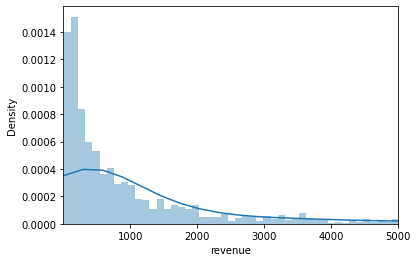

In [27]:
# и сколько стоят сформированные заказы:
plt.xlim(1,5000)
sns.distplot(df.groupby('product')['revenue'].sum(), bins = 500);

Распределение сильно смещено, преобладают низкие по стоимости заказы.

## 2.2. Категоризация товарного ассортимента:

In [28]:
#со сколькими уникальными названиями нам придется работать:
len(df['product'].unique())

2243

In [29]:
def create_season_category(row):
    if row == 12 or row == 1 or row==2:
        return 'winter'
    if row == 3 or row == 4 or row == 5:
        return 'spring'
    if row == 6 or row == 7 or row == 8:
        return 'summer'
    if row == 9 or row == 10 or row == 11:
        return 'autumn'
df['season'] = df['month'].apply(create_season_category)
  

Теперь предстоит самая трудоемкая категоризация - по группам назначения товаров. Сначала посмотрим на уникальные названия:

In [30]:
with pd.option_context('display.max_rows', None):
    display(df['product'].value_counts())

Пеларгония розебудная Red Pandora укорененный черенок                                                                               62
Пеларгония розебудная Prins Nikolai укорененный черенок                                                                             53
Пеларгония зональная диам. 12 см сиреневый полумахровый                                                                             51
Сумка-тележка 2-х колесная Gimi Argo синяя                                                                                          42
Пеларгония розебудная Mary укорененный черенок                                                                                      37
Пеларгония розебудная Margaretha укорененный черенок                                                                                28
Пеларгония розебудная Queen Ingrid укорененный черенок                                                                              27
Пеларгония зональная махровая лососевая                

In [31]:
# приведем все значения столбца 'product'к нижнему регистру:
df['product'] = df['product'].str.lower()

In [32]:
# лемматизацию начинаем с выделения уникальных значений из столбца 'product'
m = Mystem()
unique_products = df['product'].unique() 
# соеденим в строку
unique_products = ' '.join(unique_products)
lemmas = m.lemmatize(unique_products)
# поможет в этом специальный контейнер из модуля collections
Counter(lemmas)

Counter({'комнатный': 24,
         ' ': 16969,
         'растение': 29,
         'в': 264,
         'горшок': 123,
         'алый': 3,
         'вера': 2,
         ', ': 1038,
         'd12': 30,
         'h30': 5,
         'кофе': 6,
         'арабика': 5,
         'h25': 22,
         'радермахер': 1,
         'd': 244,
         '-': 926,
         '12': 144,
         'см': 1015,
         'h': 55,
         '20': 68,
         'хризолидокарпус': 1,
         'лутесценс': 1,
         '9': 119,
         'циперус': 1,
         'зумул': 1,
         '25': 40,
         'шеффлер': 2,
         'лузеан': 1,
         'юкка': 1,
         'нитчатый': 1,
         '35': 8,
         'настенный': 27,
         'сушилка': 110,
         'для': 519,
         'белье': 132,
         'gimi': 69,
         'brio': 4,
         'super': 7,
         '100': 54,
         'таз': 34,
         'пластмассовый': 58,
         '21': 18,
         ',': 287,
         '0': 159,
         'л': 245,
         'круглый': 22,
        

In [33]:
#создаем отдельные переменные, которые будут хранить список полученных лемм по категориям принадлежности:
sad_i_ogorod = ['многолетний', 'тимьян', 'чабрец', 'рассада', 'зелень','базилик', 'мелисса', 'яблочко', 'виноград', 'томат',
                'тыква', 'кориандр', 'шалфей', 'сантолина', 'лекарственный', ' аспарагус', 'душица', 'петуния', 'патиссон',
               'арбуз', 'годеция', 'горох', 'дыня', 'земляника', 'календула', 'капуста', 'клубника', 'цинния', 'колокольчик',
               'петрушка', 'огурец', 'морковь', 'салат', 'сельдерей', 'тюльпан', 'укроп', 'флокс', 'настурция', 'лук', 'лаватера',
               'лен', 'эшшольция', 'цинерария', 'табак']
komnatnije_rastenia = ['растение', 'радермахер', 'хризолидокарпус', 'лутесценс', 'циперус', 'зумул',  'шеффлер', 'герань',
                     'пеларгония', 'цветок', 'цикламен', 'хлорофитум', 'глоксиния', 'азалия', 'гортензия','хризантема',
                      'горшок', 'кассета','мирт', 'афеляндр', 'скуаррос', 'кашпо', 'фиалка', 'роза', 'горшке', 'см', 'алиссум',
                      'аквилегия', 'анемона', 'антуриум', 'астра', 'бакопа', 'бархатцы', 'бузульник', 'валериана', 'вербена',
                      'вербейник', 'вероника', 'вигна', 'виола', 'гайлардия', 'гвоздика', 'георгина', 'гиностемма',
                       'дендробиум', 'змееголовник', 'калибрахоа', 'калла', 'камнеломка', 'кодонанта',  'фуксия', 'лапчатка',
                      'лобелия', 'любисток', 'монарда', 'нивянник', 'овсянница', 'рудбекия', 'кореопсис', 'котовник', 'ясколка', 'эхинацея',
                      'энотера', 'физостегия', 'седум', 'пиретрум', 'хоста', 'солидаг']
kitchen = ['кухня', 'тарелка', 'обеденный', 'столовая', 'ложка', 'нож', 'котел', 'крышка', 'посуда',  'кружка', 'овощ',
         'фужер', 'вино', 'контейнер', 'толкушка', 'чайник', 'кухонный','сковорода', 'миксер','керамический', 'керамика', 'термос',
          'бидон', 'блюдо', 'блюдце', 'бульонница', 'венчик', 'посуды', 'соуса','картофелемялка', 'кастрюля', 'ковш', 'чайный',
          'хлебница', 'выпечки', 'терка', 'тортница', 'кондитерский', 'столовых', 'стаканов', 'кружек', 'бокалов', 'миска', 'лоток',
          'емкость', 'кувшин', 'рыбочистка', 'скалка', 'совок', 'стакан', 'чеснока', 'вишен', 'плиту', 'орехоколка',
          'посудомоечных', 'пьезозажигалка']
interior = ['настенный', 'потолочный', 'муляж', 'магнит', 'подставка', 'фарфор', 'коврик', 'интерьерный',
                    'ковер', 'ванна',  'дверной', 'сердце', 'настольный',  'карниз', 'композиция', 'искусственная',
           'искусственный', 'штор', 'этажерка', 'стеллаж', 'комод', 'сиденье', 'обувница-3', 'подголовник', 'мыльница',
           'пробка', 'коробка', 'кофр', 'ящик']
uborka= ['сушилка', 'таз', 'гладильный','доска', 'крючок', 'корзина', 'щетка', 'ерш', 'прищепок', 'дозатор', 'унитазный',
          'стремянка', 'стиральный', 'пыль', 'зубной', 'веник', 'ведро', 'ёрш', 'отжим', 'банка', 'ведра', 'антижир',
         'антинакипин', 'налета', 'белья', 'мытья', 'вантуз', 'губка', 'туалетной', 'мыло', 'соль', 'паста', 'швабра ', 'пятен',
        'чистки', 'микрофибры', 'окномойка', 'салфетки', 'скребок', 'перчатки', 'насадка', 'пена', 'маска']
tekstil = ['белье', 'хлопок', 'полумахровый', 'махровый', 'плед', 'скатерть', 'хлопковый', 'простыня', 'односпальный', 'штора',
           'текстильный', 'подушка', 'полотенце', 'салфетка', 'подрукавник', 'жаккард', 'одеяло']
clothes = ['чехол', 'вешалка', 'брюки', 'одежный', 'костюм', 'плечики', 'одежда', 'платье', 'вешалки', ' вешалок']
bags = ['сумка', 'тележка']
technika = ['фен', 'утюг', 'соковыжималка', 'соковарка', 'мантоварка', 'весы', 'пылесос']
stroika = ['веревка', 'завертка', 'лопатка', 'инструмент', 'инструментов', 'сверел', 'штангенциркуль', 'шнур', 'шило', 'сварка',
          'уголок', 'стяжка', 'стремянки', 'сверло-фреза', 'петля', 'ручка', 'корыто', 'сверло', 'фал', 'фиксатор-шар',
          'бензин']

Итак, мы выделили следующик категории товаров:
- **сад и огород** - семена и рассада;
- **комнатные растения** - растения для выращивания в горшках, а так же сами горшки и кассеты;
- **все для кухни** - все, что связано с кухней и готовкой: от кастрюль до моющих средств;
- **интерьер и декор** - все, что предназначено для украшения , а также для организации хранения;
- **быт и уборка** - все, что связано с наведением чистоты и порядка;
- **текстиль** - все тканевое: от одеял до салфеток;
- **для гардеробной** - все, что предназначено для хранения и уходом за одеждой:
- **сумки** - для транспортировки;
- **техника** - приборы для дома;
- **стройматериалы** - от инструментов до строительной фольги.


In [34]:
def create_product_category(product_column):
    for i in sad_i_ogorod:
        if i in product_column:
            return 'сад и огород'
    for i in komnatnije_rastenia:
        if i in product_column:
            return 'комнатные растения'
    for i in kitchen:
        if i in product_column:
            return 'все для кухни'
    for i in interior:
        if i in product_column:
            return 'интерьер и декор'
    for i in uborka:
        if i in product_column:
            return 'быт и уборка'
    for i in tekstil:
        if i in product_column:
            return 'текстиль'
    for i in clothes:
        if i in product_column:
            return 'для гардеробной'
    for i in bags:
        if i in product_column:
            return 'сумки'
    for i in technika:
        if i in product_column:
            return 'техника'
    for i in stroika:
        if i in product_column:
            return 'стройматериалы'

In [35]:
df['product_category']= df['product'].apply(create_product_category)

В качестве промежуточного итога из проведенных манипуляций с названиями товаров возникла идея закодировать товар в специальный id, в номере которого будет содержаться информация о принадлежности к товарной категории. Я бы поработала над структурой базы и оргпнизацией хранения информации. Так будет проще всем.

### 2.3. Анализ продаж в разрезе товарных категорий

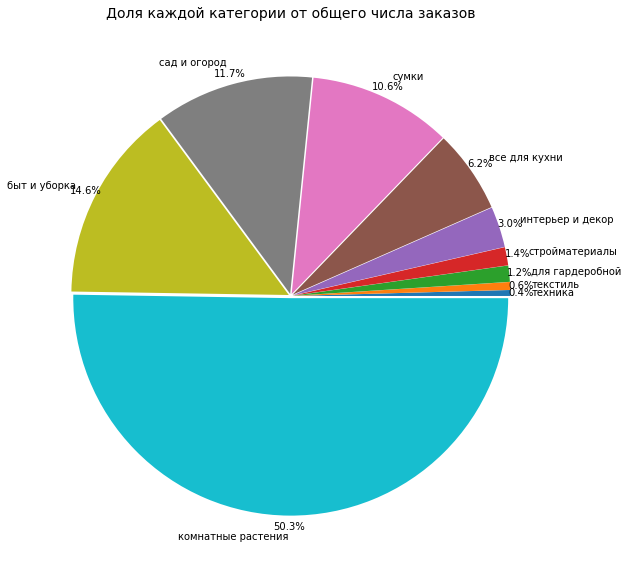

In [36]:
#СхемаСх объема продаж по категориям от общего количества
category_pivot = df.groupby('product_category')[['order_id']].nunique().sort_values(by='order_id')
plt.figure(figsize = (10, 10))
plt.pie(category_pivot['order_id'], labels=category_pivot.index, autopct='%.1f%%', explode=[0.01]*10, pctdistance=1.05)
plt.title('Доля каждой категории от общего числа заказов', fontsize=14)
plt.show()

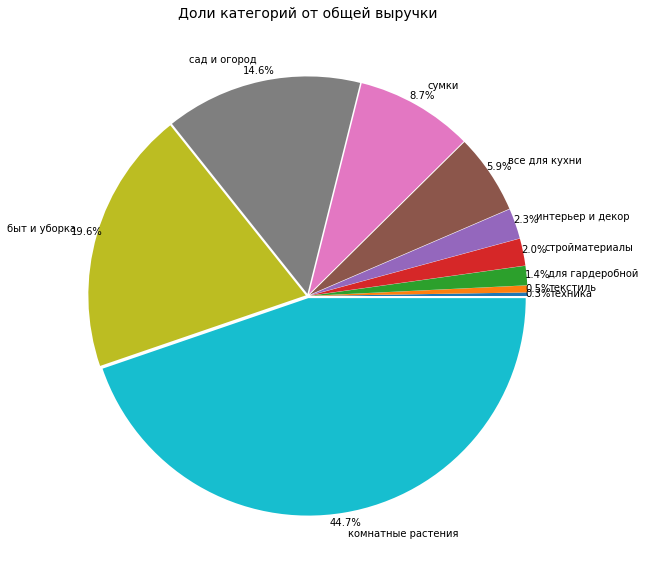

In [37]:
# Схема распределения выручки по категориям товаров:
category_revenue_pivot = df.groupby('product_category')[['revenue']].sum().sort_values(by='revenue')
plt.figure(figsize = (10, 10))
plt.pie(category_revenue_pivot['revenue'], labels=category_pivot.index, autopct='%.1f%%', explode=[0.01]*10, pctdistance=1.05)
plt.title('Доли категорий от общей выручки', fontsize=14)
plt.show()

Выручка прямо пропорциональная количеству заказов: доля от общего числа продаж соразмерна доле категории товара от общей выручки. Еще это означает, скорее всего, что дешевые товары покупают в большем количестве. Проверим это и посмотрим на среднюю цену на товары в каждой категории:

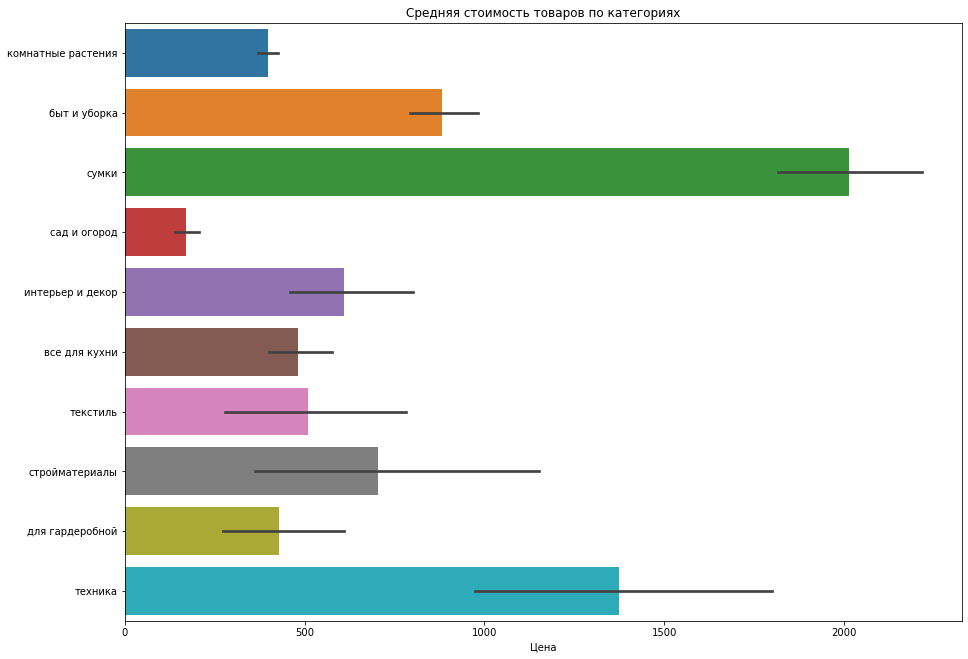

In [38]:
plt.figure(figsize=(15, 11))
sns.barplot(data=df, y='product_category', x='price')
plt.xlabel('Цена')
plt.ylabel('')
plt.title('Средняя стоимость товаров по категориях')
plt.show()
#почему-то параметр order=df["feature"], orient="h" кладет юпитер. Хотела отсортировать значения без группировки данных.

Дороже всего стоят сумки и тележки(!) Только на втором месте техника, на третьем инструменты для строительства. Комнатные растения, которые приносят больше всего выручки, стоят ожидаемо недорого.

In [39]:
#посмотрим, как распределены заказы по количеству в категориях в абсолютных значениях
orders_by_quantity = df.groupby('product_category').agg({'order_id':'nunique'}).reset_index()
orders_by_quantity

,product_category,order_id
0,быт и уборка,401
1,все для кухни,169
2,для гардеробной,33
3,интерьер и декор,83
4,комнатные растения,1377
5,сад и огород,321
6,стройматериалы,37
7,сумки,291
8,текстиль,16
9,техника,12


Заказы по категориям распределены очень неравномерно: невозможно построить боксплоты в одной плоскости. Скорее всего, в данных присутствуют выбросы. Но обрезать датасет мы больше не будем, примем за возможность пользование услугами интернет-магазина крупных компаний.

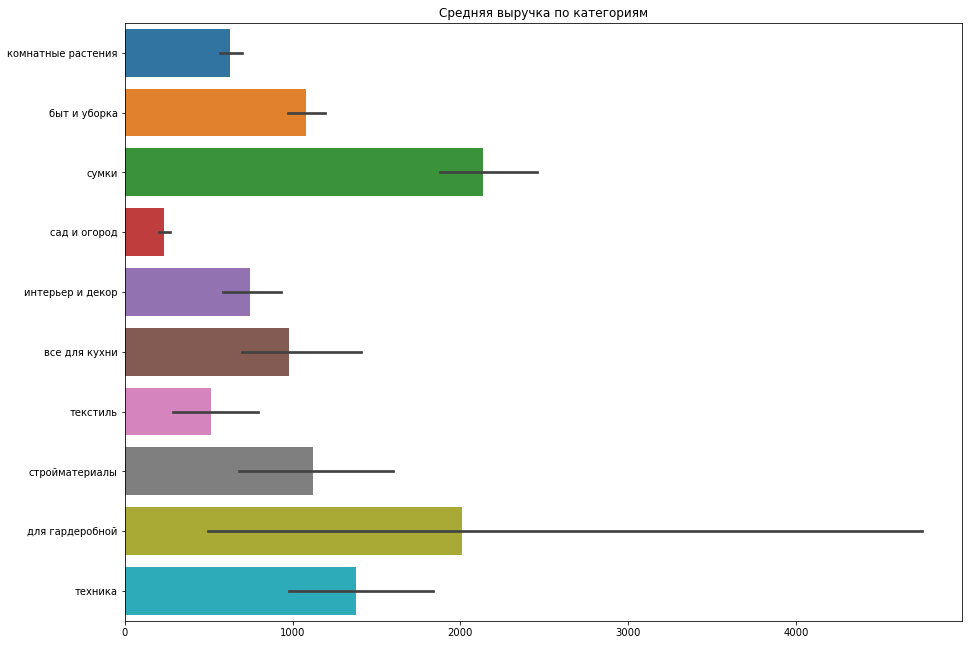

In [40]:
#посмотрим на распределение средней выручки внутри товарных категорий:
revenue_cat = df.groupby('product_category').agg({'revenue':'mean'}).reset_index()
plt.figure(figsize=(15, 11))
sns.barplot(data=df, y='product_category', x='revenue')
plt.xlabel('')
plt.ylabel('')
plt.title('Средняя выручка по категориям')
plt.show()

Самые высокие показатели у категории, в которую входят товары, связанные с уходом и хранением одежды и категории сумки/тележки.Немного отстает техника для дома.

### 2.4. Анализ продаж с поправкой на сезонную категорию:

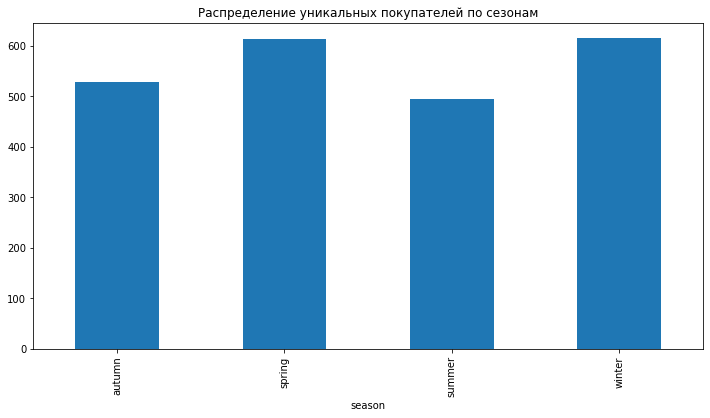

In [41]:
#Посмотрим на пользовательскую активность в зависимости от сезона покупки:
df.groupby('season').agg({'customer_id':'nunique'}).plot(kind='bar', figsize=(12, 6), legend=False)
plt.title('Распределение уникальных покупателей по сезонам')
plt.show()

In [75]:
df.groupby('season').agg({'customer_id':'nunique'})

,customer_id
season,
autumn,528
spring,613
summer,495
winter,615


Количество покупателей практически одинаково весной и осенью!

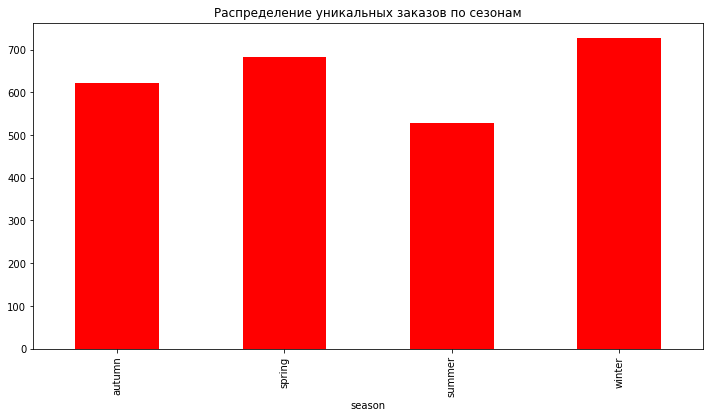

In [42]:
# посмотри на количество уникальных заказов:
df.groupby('season').agg({'order_id':'nunique'}).plot(kind='bar', color='red', figsize=(12, 6), legend=False)
plt.title('Распределение уникальных заказов по сезонам')
plt.show()

In [76]:
df.groupby('season').agg({'order_id':'nunique'})

,order_id
season,
autumn,622
spring,683
summer,529
winter,727


Количество заказов зимой выше, чем весной. Летом заказов значительно меньше, чем в другие сезоны.

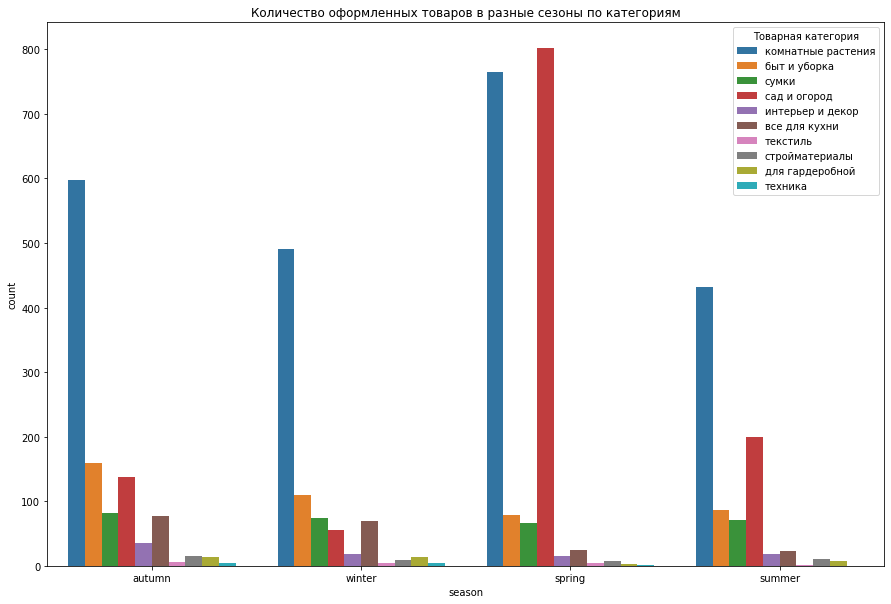

In [43]:
#А теперь посмотрим на количество уникальных заказов по сезонам в разрезе товарных категорий:
plt.figure(figsize=(15, 10))
sns.countplot(data=df, x='season', hue='product_category')
plt.title('Количество оформленных товаров в разные сезоны по категориям')
plt.legend(title='Товарная категория')
plt.show()

Стабильно высокие показатели относительно всех остальных категорий показывает "Комнатные растения". Ее опережает только рассада и только весной. Кажется, магазин на хорошем счету у любителей живых растений, нужно следить за качеством и ассортиментом. 

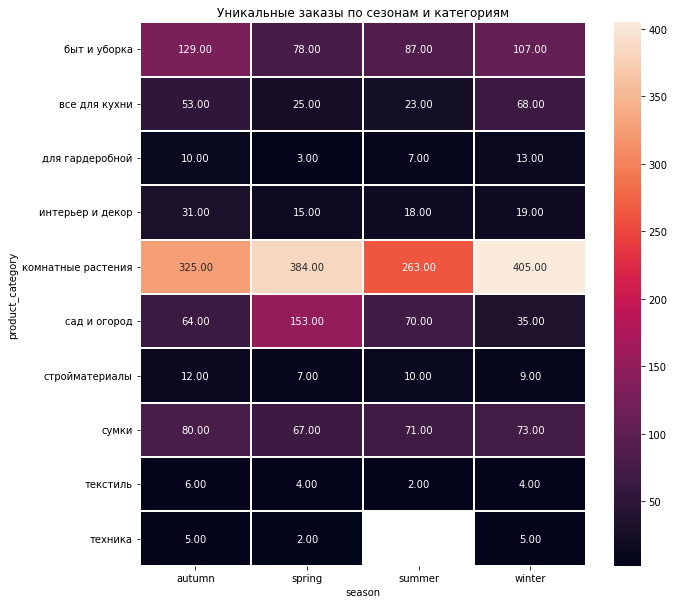

In [44]:
#остальные категории очень плохо просматриваются, посмотрим на абсолютные значениz на хитмапе
heatmap_df = df.pivot_table(index='product_category', columns='season', values='order_id', aggfunc='nunique')
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_df, annot=True, fmt='.2f', linewidth=0.1)
plt.title('Уникальные заказы по сезонам и категориям')
plt.show()

- Бытовые товары для уборки пользуются большим спросом осенью и зимоq;
- Аналогично с кухонными принадлежностями, для гардероба и интерьера;
- Комантаные растения больше всего покупают зимой и весной;
- семена и рассаду - весной;
- категории строительства и сумки примерно стабильны в течение года;
- текстиль и техника пользуются очень низким спросом, который вообще сходит на нет летом.

### 2.5 Анализ доп продаж:

In [45]:
#группируем состав заказов:
df_dop = df.groupby(['order_id', 'product', 'product_category', 'price']).agg({'quantity':'sum'}).reset_index()
df_dop

,order_id,product,product_category,price,quantity
0,12624,"осина обыкновенная, высота 25-50 см",комнатные растения,150.00,1
1,12624,"осина обыкновенная, высота 50-100 см",комнатные растения,225.00,1
2,13547,рассада зелени для кухни лаванды в кассете по ...,сад и огород,315.00,1
3,13547,рассада зелени для кухни розмарина в кассете п...,сад и огород,207.00,1
4,13547,рассада зелени для кухни тимьяна в кассете по ...,сад и огород,162.00,1
...,...,...,...,...,...
4570,72805,тележка багажная delta dt-23 грузоподъемность ...,сумки,1124.00,1
4571,72806,совок для золы металлический с длинной металли...,все для кухни,74.00,1
4572,72810,герань домашняя (пеларгония зональная) цветуща...,комнатные растения,157.00,1
4573,72811,кружка с трубочкой attribute мяч 500 мл jar501,все для кухни,76.00,60


In [46]:
#добавляем стоимость
df_dop['revenue']= df_dop['price']*df_dop['quantity']
df_dop

,order_id,product,product_category,price,quantity,revenue
0,12624,"осина обыкновенная, высота 25-50 см",комнатные растения,150.00,1,150.00
1,12624,"осина обыкновенная, высота 50-100 см",комнатные растения,225.00,1,225.00
2,13547,рассада зелени для кухни лаванды в кассете по ...,сад и огород,315.00,1,315.00
3,13547,рассада зелени для кухни розмарина в кассете п...,сад и огород,207.00,1,207.00
4,13547,рассада зелени для кухни тимьяна в кассете по ...,сад и огород,162.00,1,162.00
...,...,...,...,...,...,...
4570,72805,тележка багажная delta dt-23 грузоподъемность ...,сумки,1124.00,1,1124.00
4571,72806,совок для золы металлический с длинной металли...,все для кухни,74.00,1,74.00
4572,72810,герань домашняя (пеларгония зональная) цветуща...,комнатные растения,157.00,1,157.00
4573,72811,кружка с трубочкой attribute мяч 500 мл jar501,все для кухни,76.00,60,4560.00


In [47]:
#создаем датасет для мерджа, чтобы пристегнуть итоговую стоимость заказа
df_order_revenue = df.groupby('order_id')['revenue'].sum().reset_index()
display(df_order_revenue)


,order_id,revenue
0,12624,375.00
1,13547,684.00
2,14480,359.00
3,14481,600.00
4,14482,376.00
...,...,...
2554,72805,1124.00
2555,72806,74.00
2556,72810,157.00
2557,72811,4560.00


сделать топы недорогих товаров.

In [48]:
#мерджим
df_dop_osn = df_dop.merge(df_order_revenue, on = ['order_id'], how = 'outer')


In [49]:
df_dop_osn.columns = ['order_id', 'product', 'product_category', 'price', 'quantity', 'product_revenue', 'order_revenue']
df_dop_osn

,order_id,product,product_category,price,quantity,product_revenue,order_revenue
0,12624,"осина обыкновенная, высота 25-50 см",комнатные растения,150.00,1,150.00,375.00
1,12624,"осина обыкновенная, высота 50-100 см",комнатные растения,225.00,1,225.00,375.00
2,13547,рассада зелени для кухни лаванды в кассете по ...,сад и огород,315.00,1,315.00,684.00
3,13547,рассада зелени для кухни розмарина в кассете п...,сад и огород,207.00,1,207.00,684.00
4,13547,рассада зелени для кухни тимьяна в кассете по ...,сад и огород,162.00,1,162.00,684.00
...,...,...,...,...,...,...,...
4570,72805,тележка багажная delta dt-23 грузоподъемность ...,сумки,1124.00,1,1124.00,1124.00
4571,72806,совок для золы металлический с длинной металли...,все для кухни,74.00,1,74.00,74.00
4572,72810,герань домашняя (пеларгония зональная) цветуща...,комнатные растения,157.00,1,157.00,157.00
4573,72811,кружка с трубочкой attribute мяч 500 мл jar501,все для кухни,76.00,60,4560.00,4560.00


In [50]:
#считаем долю, которую каждая товарная позиция занимает от общей стоимости заказа. 
df_dop_osn['revenue_part']=(df_dop_osn['product_revenue']*100)/df_dop_osn['order_revenue']
df_dop_osn

,order_id,product,product_category,price,quantity,product_revenue,order_revenue,revenue_part
0,12624,"осина обыкновенная, высота 25-50 см",комнатные растения,150.00,1,150.00,375.00,40.00
1,12624,"осина обыкновенная, высота 50-100 см",комнатные растения,225.00,1,225.00,375.00,60.00
2,13547,рассада зелени для кухни лаванды в кассете по ...,сад и огород,315.00,1,315.00,684.00,46.05
3,13547,рассада зелени для кухни розмарина в кассете п...,сад и огород,207.00,1,207.00,684.00,30.26
4,13547,рассада зелени для кухни тимьяна в кассете по ...,сад и огород,162.00,1,162.00,684.00,23.68
...,...,...,...,...,...,...,...,...
4570,72805,тележка багажная delta dt-23 грузоподъемность ...,сумки,1124.00,1,1124.00,1124.00,100.00
4571,72806,совок для золы металлический с длинной металли...,все для кухни,74.00,1,74.00,74.00,100.00
4572,72810,герань домашняя (пеларгония зональная) цветуща...,комнатные растения,157.00,1,157.00,157.00,100.00
4573,72811,кружка с трубочкой attribute мяч 500 мл jar501,все для кухни,76.00,60,4560.00,4560.00,100.00


In [51]:
#Дополнительной считаем ту продажу, которая занимает меньше 20 % стоимости заказа (Закон Парето, когда 20 процентов товаров 
#формируют 80 процентов стоимости, а 80 процентов товаров - 20 процентов стоимости.)
def create_part_category(row):
    if row <= 20:
        return 'доп продажа'
    else:
        return 'основная'
df_dop_osn['part_category'] = df_dop_osn['revenue_part'].apply(create_part_category)

In [52]:
df_dop_osn

,order_id,product,product_category,price,quantity,product_revenue,order_revenue,revenue_part,part_category
0,12624,"осина обыкновенная, высота 25-50 см",комнатные растения,150.00,1,150.00,375.00,40.00,основная
1,12624,"осина обыкновенная, высота 50-100 см",комнатные растения,225.00,1,225.00,375.00,60.00,основная
2,13547,рассада зелени для кухни лаванды в кассете по ...,сад и огород,315.00,1,315.00,684.00,46.05,основная
3,13547,рассада зелени для кухни розмарина в кассете п...,сад и огород,207.00,1,207.00,684.00,30.26,основная
4,13547,рассада зелени для кухни тимьяна в кассете по ...,сад и огород,162.00,1,162.00,684.00,23.68,основная
...,...,...,...,...,...,...,...,...,...
4570,72805,тележка багажная delta dt-23 грузоподъемность ...,сумки,1124.00,1,1124.00,1124.00,100.00,основная
4571,72806,совок для золы металлический с длинной металли...,все для кухни,74.00,1,74.00,74.00,100.00,основная
4572,72810,герань домашняя (пеларгония зональная) цветуща...,комнатные растения,157.00,1,157.00,157.00,100.00,основная
4573,72811,кружка с трубочкой attribute мяч 500 мл jar501,все для кухни,76.00,60,4560.00,4560.00,100.00,основная


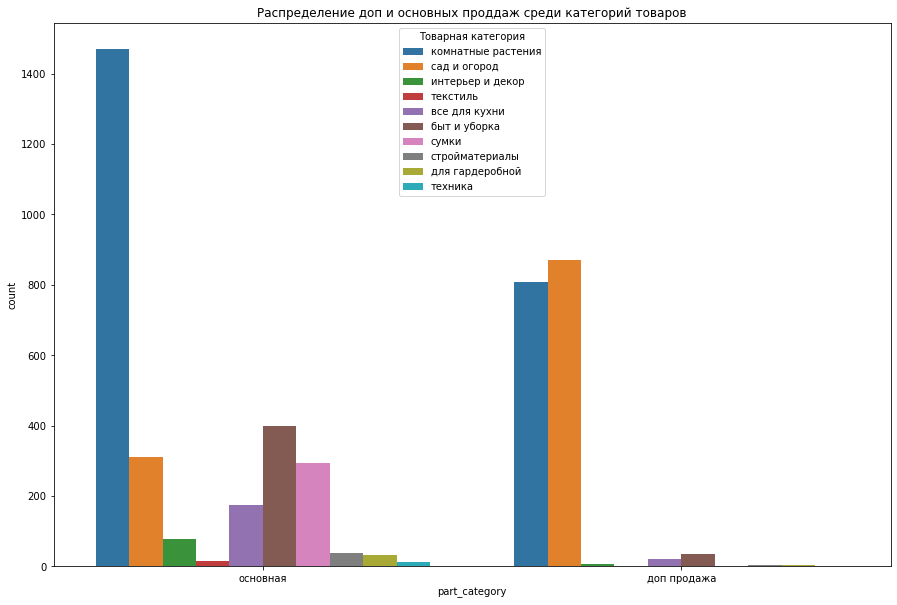

In [53]:
plt.figure(figsize=(15, 10))
sns.countplot(data=df_dop_osn, x='part_category', hue='product_category')
plt.title('Распределение доп и основных проддаж среди категорий товаров')
plt.legend(title='Товарная категория')
plt.show()

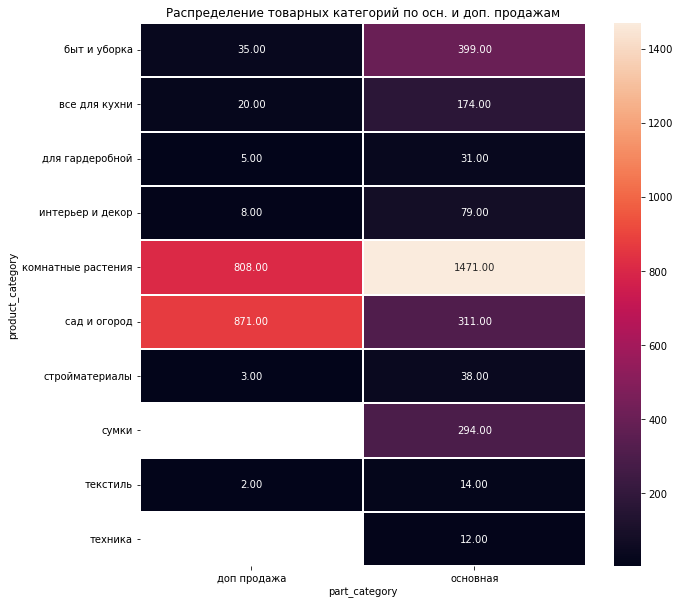

In [78]:
#остальные категории очень плохо просматриваются, посмотрим на абсолютные значениz на хитмапе
heatmap_df_dop_osn = df_dop_osn.pivot_table(index='product_category', columns= 'part_category', values='product', aggfunc='count')
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_df_dop_osn, annot=True, fmt='.2f', linewidth=0.1)
plt.title('Распределение товарных категорий по осн. и доп. продажам')
plt.show()

В качестве доп продаж хорошо идут растения и семена-рассада, это комплиментарные категории. Если в заказ попал товар данной категории, можно сразу предложить доп товар из комплиментарной. Для остальных категорий можно попробовать настроить алгоритм предложения так, чтобы отображался товар стоимостью не больше 0,25 от самого крупного заказа в корзине, из той же категории, в которой находится самый крупный товар, а если таковые отсутствуют, то из самых популярных категорий "семена/комнатные цветы". К сожалению, такой алгоритм я написать не могу.

### 2.6. Итоги исследовательского анализа:

- Среди данных абсолютно преобладают заказы до 8 позиций;
- Среди товарных категорий выделены 10 явных групп. Дальнейшие результаты исследования можно принять только с поправкой, что группы сформированы корректно, в связи с чем есть предложений ораганизовать хранение наименований уникальных позиций в виде кода (товарного id), содержащего маркировку принадлежности у определенной товарной категории;
- До половины заказов содержат товары из категории комнатных растений, которые приносят 44,7 процента выручки;
- Большей популярность пользуются негабаритные товары с низкой стоимостью;
- Самое большое количество покупателей наблюдается весной (поплуярной становится категория "сад и огород", включающая семена и рассаду;
- Категории комнатных растений востребованы как в сегменте основных продаж, так и дополнительных.

## 3. Кластеризация

### 3.1. Дендрограмма

In [54]:
# выделяем из датасета выборку с признаками, по которым будем строить товарные кластеры:
df_for_clusters = df[['price', 'quantity', 'revenue']]

In [55]:
#создание объекта класса StandardScaler и применение его к обучающей выборке
scaler = StandardScaler()
df_sc = scaler.fit_transform(df_for_clusters)
linked = linkage(df_sc, method = 'ward') 

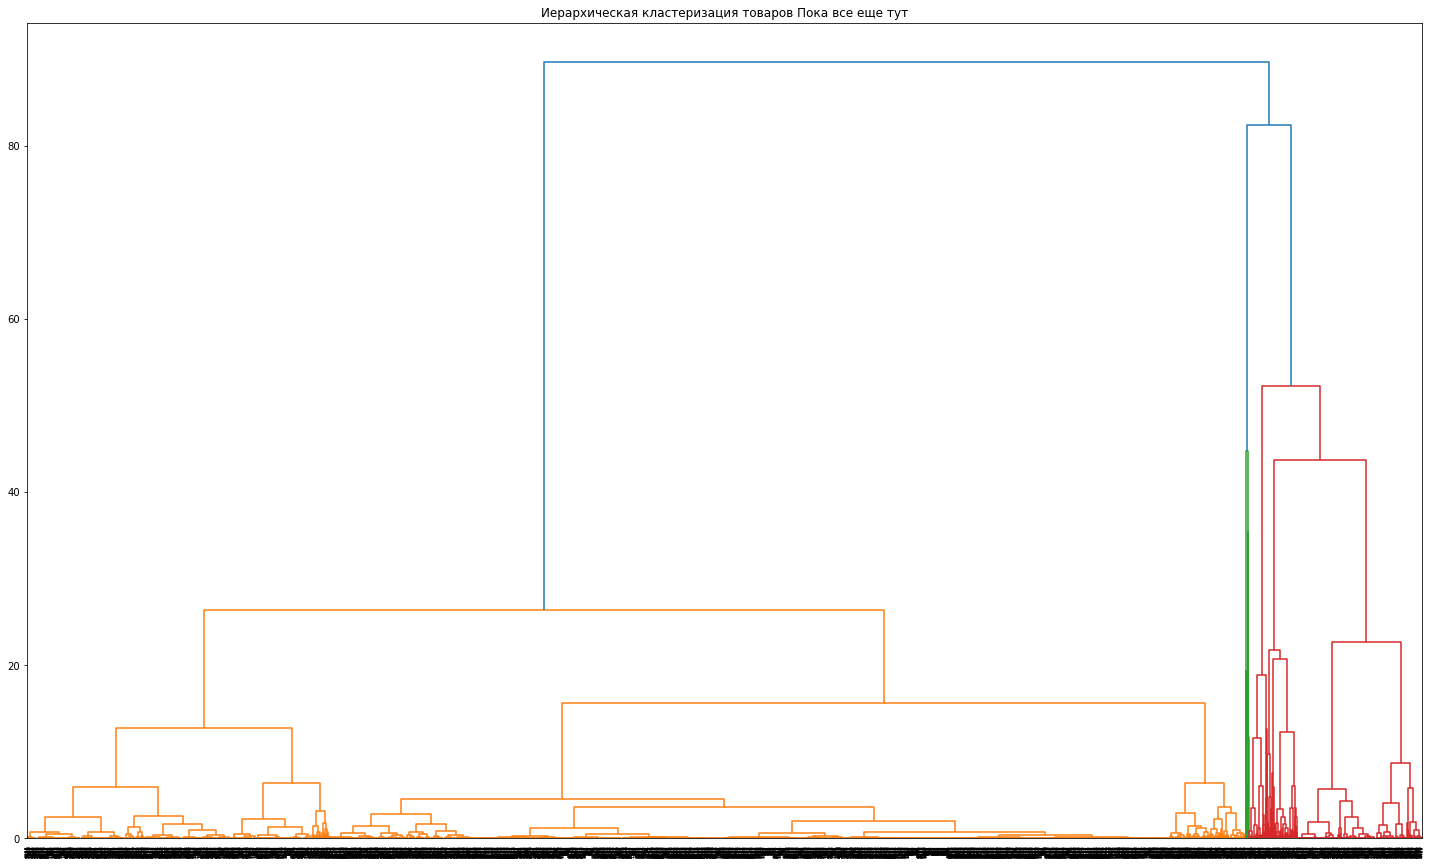

In [56]:
plt.figure(figsize=(25, 15))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация товаров Пока все еще тут')
plt.show() 

Очень неоднозначное разделение. Выделяем 3 кластера:

### 3.2. Метод К-средних

In [57]:
model_km = KMeans(n_clusters = 3, random_state = 0)# задаём число кластеров, равное 3, 
#и фиксируем значение random_state для воспроизводимости результата
labels = model_km.fit_predict(df_sc)# применяем алгоритм к данным и формируем вектор кластеров
# сохраняем метки кластера в поле нашего датасета для построения графиков и основного
df_for_clusters['cluster_km'] = labels
df['cluster_km'] = labels

In [58]:
df_for_clusters.groupby('cluster_km')[['quantity', 'price', 'revenue']].mean()

,quantity,price,revenue
cluster_km,,,
0,2.13,299.78,410.11
1,145.57,235.64,15572.21
2,2.01,3138.38,3814.27


- **0 кластер** - малое количество товаров в заказе, низкая стоимость, небольшая выручка;
- **1 кластер** - закупают в большом количестве по низкой стоимости, приносит большую выручку;
- **2 кластер** - закупают в малом количестве, по высокой цене, средняя выручка.

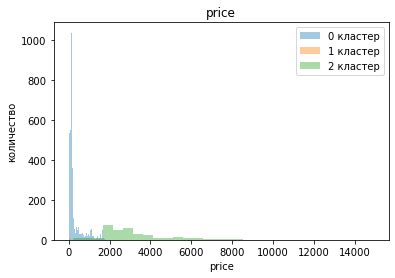

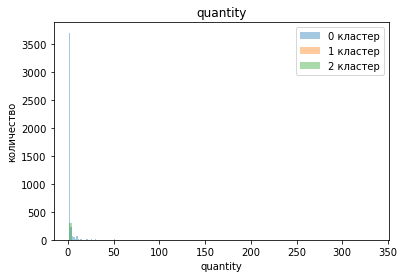

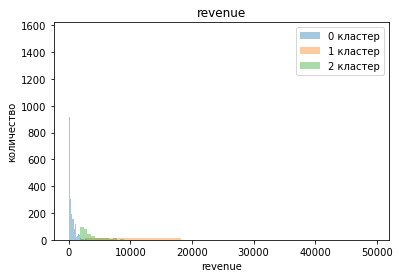

In [59]:
zero_cluster_clients = df_for_clusters.query('cluster_km == 0')
one_cluster_clients = df_for_clusters.query('cluster_km == 1')
two_cluster_clients = df_for_clusters.query('cluster_km == 2')
fig, ax = plt.subplots()
for column in df_for_clusters.drop('cluster_km', axis = 1).columns:
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('количество')
    sns.distplot(zero_cluster_clients[column], label='0 кластер', kde=False)
    sns.distplot(one_cluster_clients[column], label='1 кластер', kde=False)
    sns.distplot(two_cluster_clients[column], label='2 кластер', kde=False)
    plt.legend()
    plt.show()

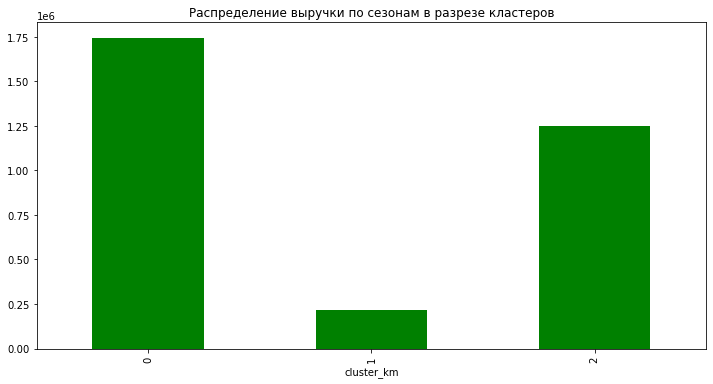

In [79]:
#посмотрим на графике соотношение выручки в кластерах.
df.groupby('cluster_km').agg({'revenue':'sum'}).plot(kind='bar', color='green', figsize=(12, 6), legend=False)
plt.title('Распределение выручки по сезонам в разрезе кластеров')
plt.show()

In [80]:
df.groupby('cluster_km').agg({'revenue':'sum'})

,revenue
cluster_km,
0,1744181.00
1,218011.00
2,1251082.00


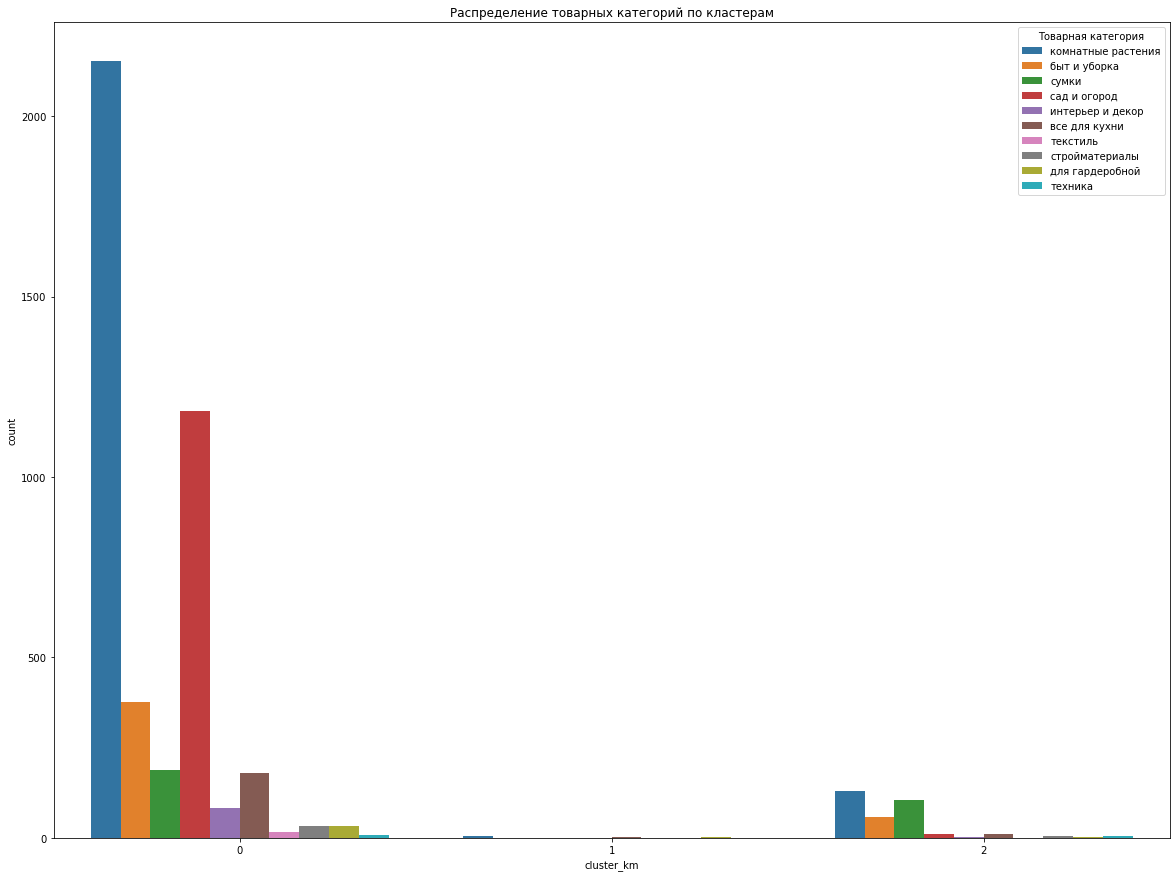

In [61]:
plt.figure(figsize=(20, 15))
sns.countplot(data=df, x='cluster_km', hue='product_category')
plt.title('Распределение товарных категорий по кластерам')
plt.legend(title='Товарная категория')
plt.show()

### 3.3. Выводы по итогам кластеризации

**По цене:**
- 0 кластер - это товары с низкой стоимостью и популярные среди пользователей;
- 1 кластер - совсем камерная категория, низкая по цене и непопулярная;
- 2 кластер - это товары подороже и с меньшим, но стабильным спросом.

**По частоте спроса**
- 0 кластер - самые ходовые;
- 1 кластер - неходовые;
- 2 клстер - стабильно низко ходовые.

**По выручке**
- 0 кластер - приносят мало выручки;
- 1 кластер - высокая выручка за счет высокой стоимости;
- 2 кластер - средняя выручка.

## 4. Проверка гипотез:

### 4.1. Проверка гипотезы о равенстве среднего чека в кластерах:

In [62]:
#таблица для вычислений:
df_for_avg_check = df.pivot_table(
    index=['order_id','cluster_km'], values=['product', 'revenue'], aggfunc={'product':'nunique', 'revenue':'sum'}).reset_index()
df_for_avg_check['avg_check'] = df_for_avg_check['revenue'] / df_for_avg_check['product']

In [63]:
cluster_0_avg = df_for_avg_check[df_for_avg_check['cluster_km'] == 0]['avg_check']
cluster_1_avg = df_for_avg_check[df_for_avg_check['cluster_km'] == 1]['avg_check']
cluster_2_avg = df_for_avg_check[df_for_avg_check['cluster_km'] == 2]['avg_check']

In [64]:
cluster_0_avg.head()

0   187.50
1   228.00
2   119.67
3   150.00
4   188.00
Name: avg_check, dtype: float64

In [65]:
#оценим дисперсию сформированных выборок:
print('Дисперсия по среднему чеку в 0 кластере:', cluster_0_avg.describe()['std']**2)
print('Дисперсия по среднему чеку в 1 кластере:', cluster_1_avg.describe()['std']**2)
print('Дисперсия по среднему чеку во 2 кластере:', cluster_2_avg.describe()['std']**2)

Дисперсия по среднему чеку в 0 кластере: 373174.1902116565
Дисперсия по среднему чеку в 1 кластере: 297560083.85897446
Дисперсия по среднему чеку во 2 кластере: 6390274.9031970175


Дисперсии сильно отличаются друг от друга. Это может означать, что распеделение в выборках и распределение генеральной совокупности не являются нормальными.

**Н0** - средние значения выборок равны;
**H1** - средние значения выборок не равны;

Для теста выберем критерий Краскала-Уоллиса (3 выборки, независимые, с не нормальным распределением). За альфу принимаем уровень в 0.05

In [66]:
H, pvalue = stats.kruskal(cluster_0_avg, cluster_1_avg, cluster_2_avg)

print("H-statistic:", H)
print("P-Value:", pvalue)

if pvalue < 0.05:
    print("Отвергаем нулевую гипотезу - статистически значимая разница есть")
if pvalue > 0.05:
    print("Не получилось отвергнуть нувевую гипотезу")

H-statistic: 837.5997228180593
P-Value: 1.3107841106366049e-182
Отвергаем нулевую гипотезу - статистически значимая разница есть


### 4.2. Проверка гипотезы о равенстве среднего чеков в заказов в зависимости от сезона:

In [67]:
#таблица для вычислений:
df_for_season_avg_check= df.pivot_table(
    index=['order_id','season'], values=['product', 'revenue'], aggfunc={'product':'nunique', 'revenue':'sum'}).reset_index()
df_for_season_avg_check['avg_check'] = df_for_season_avg_check['revenue'] / df_for_season_avg_check['product']

In [68]:
df_for_season_avg_check.head()

,order_id,season,product,revenue,avg_check
0,12624,summer,2,375.00,187.50
1,13547,autumn,3,684.00,228.00
2,14480,autumn,3,359.00,119.67
3,14481,autumn,4,600.00,150.00
4,14482,autumn,2,376.00,188.00


In [69]:
spring_avg = df_for_season_avg_check[df_for_season_avg_check['season'] == 'spring']['avg_check']
summer_avg = df_for_season_avg_check[df_for_season_avg_check['season'] == 'summer']['avg_check']
autumn_avg = df_for_season_avg_check[df_for_season_avg_check['season'] == 'autumn']['avg_check']
winter_avg = df_for_season_avg_check[df_for_season_avg_check['season'] == 'winter']['avg_check']

In [70]:
#оценим дисперсию сформированных выборок:
print('Дисперсия по среднему чеку весной:', spring_avg.describe()['std']**2)
print('Дисперсия по среднему чеку летом:', summer_avg.describe()['std']**2)
print('Дисперсия по среднему чеку осенью:', autumn_avg.describe()['std']**2)
print('Дисперсия по среднему чеку зимой:', winter_avg.describe()['std']**2)

Дисперсия по среднему чеку весной: 2537627.3160724854
Дисперсия по среднему чеку летом: 6895257.645806438
Дисперсия по среднему чеку осенью: 2683641.6231673067
Дисперсия по среднему чеку зимой: 6358125.814546124


Дисперсии в выборках имеют большой разброс, в качестве стат теста по аналогии с пунктом 4.1. применим критерий Краскала-Уоллиса с альфа 0.05 и гипотезами:
**Н0** - средние значения выборок равны;
**H1** - средние значения выборок не равны;

In [71]:
H, pvalue = stats.kruskal(spring_avg, summer_avg, autumn_avg, winter_avg)

print("H-statistic:", H)
print("P-Value:", pvalue)

if pvalue < 0.05:
    print("Отвергаем нулевую гипотезу - статистически значимая разница есть")
if pvalue > 0.05:
    print("Не получилось отвергнуть нувевую гипотезу")

H-statistic: 41.87139789053451
P-Value: 4.27232227918498e-09
Отвергаем нулевую гипотезу - статистически значимая разница есть


В случае сезонных средних чеков также наблюдается статистически значимая разница, они не равны.

## 5. Общии выводы и рекомандации магазину

Мы проанализировали данные о заказах и входящих в них позициях интернет-магазина за год работы.
Чтобы правильно оценивать товарный ассортимент по категориям, необходимо принять единое правило классификации товаров (по назначению для определенной комнаты в доме (ванна, кухня и тп) или по материалу и т.д.). Каждой товарной позиции присвоить уникальный id, который нес бы в себе информацию о категории.
Самые главные выводы, которые сделаны в ходе исследования:
- Стабильным спросом (с возрастанием весной) пользуются товары связанные с садоводством и огородничеством, а также с украшением помещения растениями;
- Общее увеличение спроса по всем категориям идет зимой и весной;
- выделены 3 кластера товаров: 
  - 0 кластер - малое количество товаров в заказе, низкая стоимость, небольшая выручка;
  - 1 кластер - закупают в большом количестве по низкой стоимости, приносит большую выручку;
  - 2 кластер - закупают в малом количестве, по высокой цене, средняя выручка.
- Больше всего выручки приносит 0 кластер; средние чеки в кластерах не равны.


Магазину можно рекомендовать поддерживать наличие и расширять ассортимент рассады и цветов (особенно весной и летом), разнообразить категорию товаров по категорям "для гардеробной" и "сумки" (добавить в нее менее дорогие товары). Сформировать алгоритм предложения доп продажи из перечисленных категорий перед окончательным оформлением заказа.

## Ссылка на дашборд и презентацию

In [72]:
#сохраняем датасет с новыми столбцами:
df.to_csv('df_for_dashboard.csv')

дашборд:
https://public.tableau.com/views/Ecommerce-dash/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

Ссылка на презентацию:https://disk.yandex.ru/i/l4E1vnF4n9kbaw
